In [ ]:
# import package
import numpy as np 
import pandas as pd 
import os
import random
import shutil
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
print(f"TF version is: {tf.__version__}")
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

TF version is: 2.9.2


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c 'dogs-vs-cats'

100% 809M/812M [00:09<00:00, 126MB/s]
100% 812M/812M [00:09<00:00, 90.4MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("/content/dogs-vs-cats.zip","r") as z:
    z.extractall(".")  

In [ ]:
import zipfile
with zipfile.ZipFile("/content/train.zip","r") as z:
    z.extractall(".")  
with zipfile.ZipFile("/content/test1.zip","r") as z:
    z.extractall(".")

In [ ]:
# let's look at any files in the train folder
glob.glob("/content/train/*.jpg")[:10]

['/content/train/cat.5159.jpg',
 '/content/train/cat.4869.jpg',
 '/content/train/cat.6287.jpg',
 '/content/train/cat.4140.jpg',
 '/content/train/cat.7473.jpg',
 '/content/train/cat.7708.jpg',
 '/content/train/cat.9746.jpg',
 '/content/train/dog.10648.jpg',
 '/content/train/cat.9488.jpg',
 '/content/train/dog.6925.jpg']

In [ ]:
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

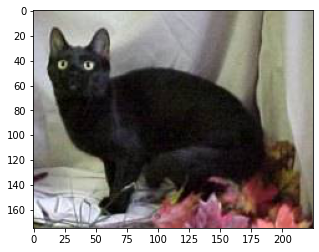

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

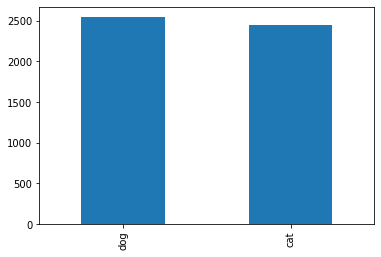

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size= 15

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
earlystop = EarlyStopping(patience=10)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

#CNN Model

##Baseline Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', 
                  input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# 32 here means this layer will contain 32 filters of size 3x3 being learnt
model.add(BatchNormalization())
# batchnorm is a useful layer that helps in convergence
model.add(MaxPooling2D(pool_size=(2, 2)))
# maxpooling will reduce the size of the image
model.add(Dropout(0.25))
# dropout is used for regularization, ensuring that model doesn't overfit
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# convolutional block is complete. now on to defining the "head"
# first flatten the matrix to get a single array
model.add(Flatten())
# adding a dense hidden layer of neurons
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# finally the output layer with neurons=number of classes and softmax activation
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

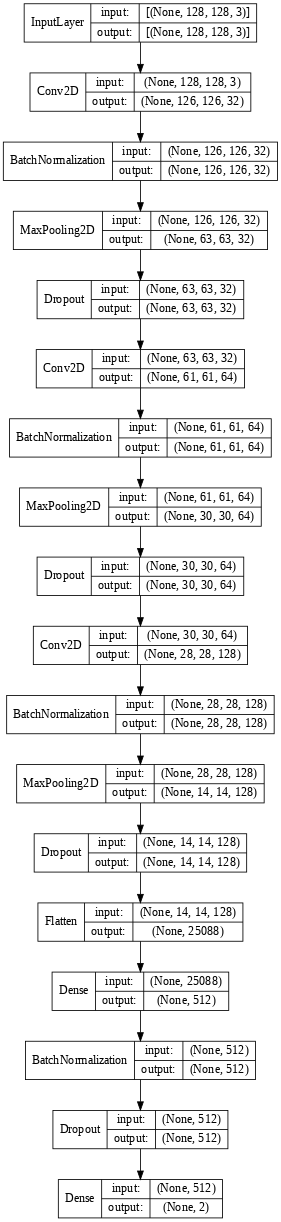

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs=3 if FAST_RUN else 20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
)

Epoch 1/20
1334/1334 [==============================] - 1146s 858ms/step - loss: 0.7615 - accuracy: 0.5975 - val_loss: 0.7591 - val_accuracy: 0.5844
Epoch 2/20
1334/1334 [==============================] - 1145s 858ms/step - loss: 0.6304 - accuracy: 0.6532 - val_loss: 0.7613 - val_accuracy: 0.6314
Epoch 3/20
1334/1334 [==============================] - 1137s 852ms/step - loss: 0.5790 - accuracy: 0.6998 - val_loss: 0.5143 - val_accuracy: 0.7354
Epoch 4/20
1334/1334 [==============================] - 1139s 854ms/step - loss: 0.5703 - accuracy: 0.7090 - val_loss: 0.5160 - val_accuracy: 0.7470
Epoch 5/20
1334/1334 [==============================] - 1133s 849ms/step - loss: 0.5339 - accuracy: 0.7365 - val_loss: 0.5047 - val_accuracy: 0.7512
Epoch 6/20
1334/1334 [==============================] - 1134s 850ms/step - loss: 0.5259 - accuracy: 0.7400 - val_loss: 0.8014 - val_accuracy: 0.6416
Epoch 7/20
1334/1334 [==============================] - 1143s 856ms/step - loss: 0.4979 - accuracy: 0.7616

In [ ]:
model.save_weights("model.h5")

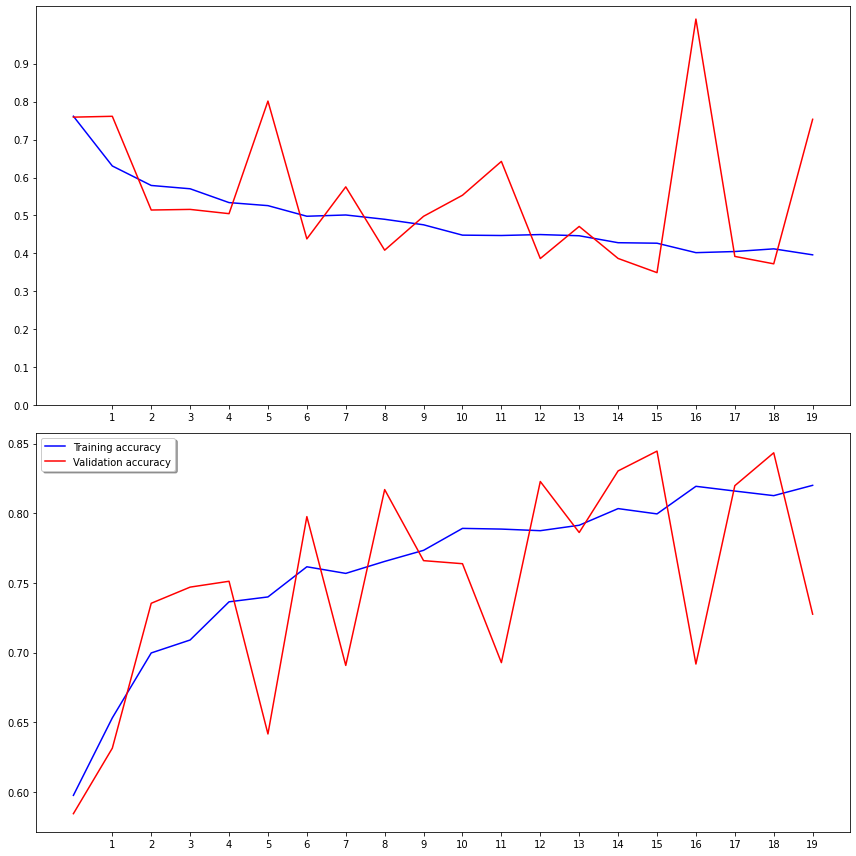

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

##Testing Data

In [ ]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


Predict Model

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-29-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

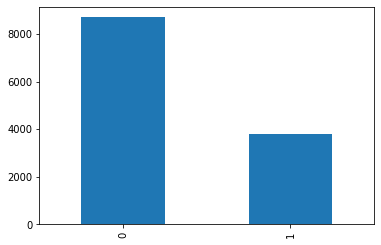

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
# let's look at any files in the train folder
glob.glob("/content/test1/*.jpg")[:10]

['/content/test1/10932.jpg',
 '/content/test1/4889.jpg',
 '/content/test1/7762.jpg',
 '/content/test1/6453.jpg',
 '/content/test1/9738.jpg',
 '/content/test1/4523.jpg',
 '/content/test1/10170.jpg',
 '/content/test1/3840.jpg',
 '/content/test1/5971.jpg',
 '/content/test1/5155.jpg']

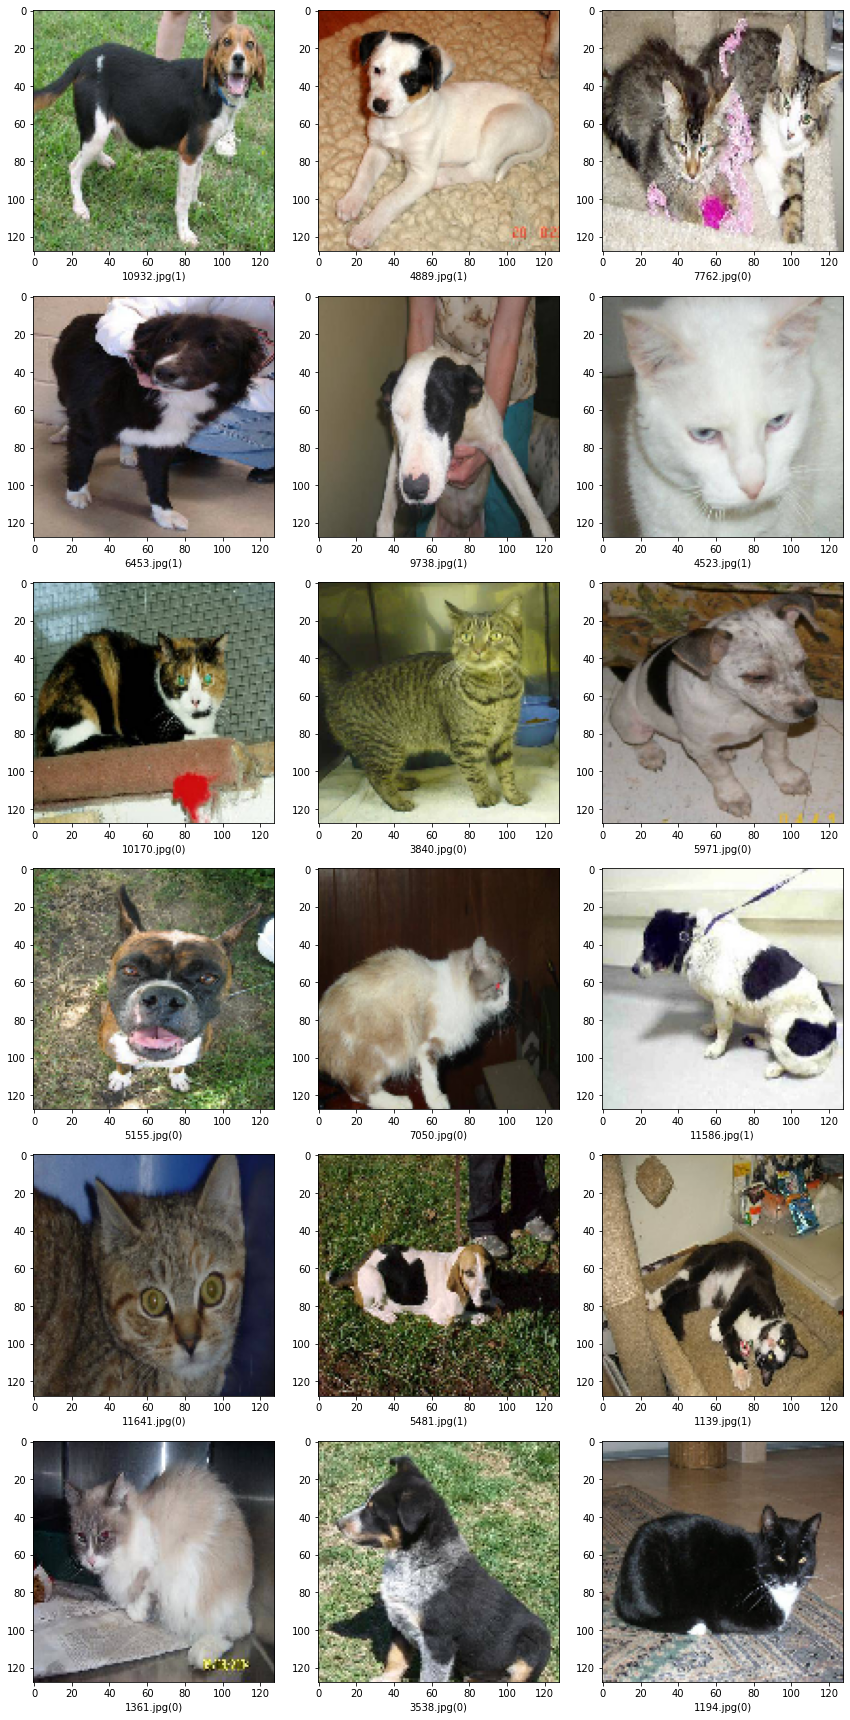

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df

,id,label
0,10932,1
1,4889,1
2,7762,0
3,6453,1
4,9738,1
...,...,...
12495,5096,0
12496,2376,1
12497,1536,1
12498,6893,0


#Model Improvement

##Improvement 1

In [ ]:
modelI1 = Sequential()

modelI1.add(Conv2D(32, (5, 5), activation='relu', 
                  input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# 32 here means this layer will contain 32 filters of size 3x3 being learnt
modelI1.add(BatchNormalization())
# batchnorm is a useful layer that helps in convergence
modelI1.add(MaxPooling2D(pool_size=(2, 2)))
# maxpooling will reduce the size of the image
modelI1.add(Dropout(0.25))
# dropout is used for regularization, ensuring that model doesn't overfit
modelI1.add(Conv2D(64, (5, 5), activation='relu'))
modelI1.add(BatchNormalization())
modelI1.add(MaxPooling2D(pool_size=(2, 2)))
modelI1.add(Dropout(0.25))
modelI1.add(Conv2D(128, (5, 5), activation='relu'))
modelI1.add(BatchNormalization())
modelI1.add(MaxPooling2D(pool_size=(2, 2)))
modelI1.add(Dropout(0.25))
modelI1.add(Conv2D(256, (5, 5), activation='relu'))
modelI1.add(BatchNormalization())
modelI1.add(MaxPooling2D(pool_size=(2, 2)))
modelI1.add(Dropout(0.25))

# convolutional block is complete. now on to defining the "head"
# first flatten the matrix to get a single array
modelI1.add(Flatten())
# adding a dense hidden layer of neurons
modelI1.add(Dense(512, activation='relu'))
modelI1.add(BatchNormalization())
modelI1.add(Dropout(0.5))
# finally the output layer with neurons=number of classes and softmax activation
modelI1.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes
modelI1.summary()
# compile model
modelI1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 64)       2

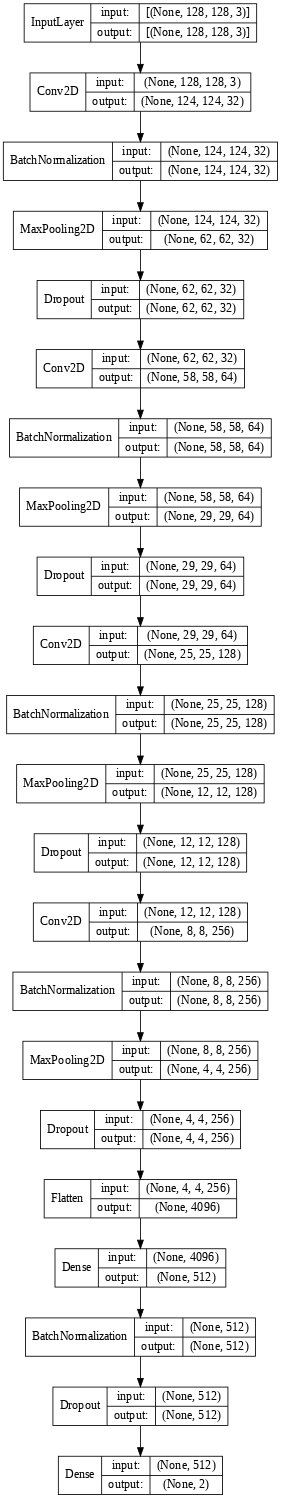

In [ ]:
plot_model(modelI1, show_shapes=True, show_layer_names=False, dpi=60)

In [ ]:
modelI1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs=3 if FAST_RUN else 35
history = modelI1.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
)

Epoch 1/35
1334/1334 [==============================] - 1878s 1s/step - loss: 0.7686 - accuracy: 0.5986 - val_loss: 0.8089 - val_accuracy: 0.5702
Epoch 2/35
1334/1334 [==============================] - 1859s 1s/step - loss: 0.6315 - accuracy: 0.6528 - val_loss: 0.6967 - val_accuracy: 0.6012
Epoch 3/35
1334/1334 [==============================] - 1839s 1s/step - loss: 0.5795 - accuracy: 0.7007 - val_loss: 0.6361 - val_accuracy: 0.6608
Epoch 4/35
1334/1334 [==============================] - 1857s 1s/step - loss: 0.5161 - accuracy: 0.7488 - val_loss: 0.6218 - val_accuracy: 0.7042
Epoch 5/35
1334/1334 [==============================] - 1848s 1s/step - loss: 0.4669 - accuracy: 0.7800 - val_loss: 0.4324 - val_accuracy: 0.8136
Epoch 6/35
1334/1334 [==============================] - 1847s 1s/step - loss: 0.4286 - accuracy: 0.8019 - val_loss: 0.7732 - val_accuracy: 0.6866
Epoch 7/35
1160/1334 [=========================>....] - ETA: 3:40 - loss: 0.4034 - accuracy: 0.8162

In [ ]:
modelI1.save_weights("modelI1.h5")

In [ ]:
for i in range(len(train_df['class'])):
    if(train_df['class'][i] == 'dog'):
        train_df['Class'] == 'dog' 
    else:    
        train_df['Class'] == 'cat'

In [ ]:
train_df2 = pd.read_excel('/content/train_df.xlsx')
train_df2.drop(['Unnamed: 0'], axis=1, inplace=True)
train_df2

,filename,class
0,C:/Users/user/extrractdata/train/train\cat.0.jpg,cat
1,C:/Users/user/extrractdata/train/train\cat.1.jpg,cat
2,C:/Users/user/extrractdata/train/train\cat.10.jpg,cat
3,C:/Users/user/extrractdata/train/train\cat.100...,cat
4,C:/Users/user/extrractdata/train/train\cat.100...,cat
...,...,...
24995,C:/Users/user/extrractdata/train/train\dog.999...,dog
24996,C:/Users/user/extrractdata/train/train\dog.999...,dog
24997,C:/Users/user/extrractdata/train/train\dog.999...,dog
24998,C:/Users/user/extrractdata/train/train\dog.999...,dog


In [ ]:
train_df2.drop(['filename'], axis=1, inplace=True)
train_df1.drop(['class'], axis=1, inplace=True)

In [ ]:
train_df1.sort('filename', ascending=False)
train_df1

AttributeError: ignored

In [ ]:
train_df = pd.DataFrame({'filename': train_df1['filename'], 'class': train_df2['class']})
train_df

,filename,class
0,/content/train/cat.5159.jpg,cat
1,/content/train/cat.4869.jpg,cat
2,/content/train/cat.6287.jpg,cat
3,/content/train/cat.4140.jpg,cat
4,/content/train/cat.7473.jpg,cat
...,...,...
24995,/content/train/cat.1407.jpg,dog
24996,/content/train/cat.981.jpg,dog
24997,/content/train/dog.8606.jpg,dog
24998,/content/train/dog.10921.jpg,dog


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()
for i in range(0,4):
    idx = random.choice(train_df.index)
    axs[i].imshow(Image.open(train_df['filename'][idx]))
    axs[i].set_title(train_df['class'][idx])